In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

        
# Common imports
import numpy as np
import os
from pathlib import Path
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# Plotting
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2
No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


In [2]:
# Data pipeline, scaling, normalizing, etc
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.mixture import GaussianMixture

# Transforming & Manipulating data
from sklearn.compose import ColumnTransformer

# The Linear Regression model
from sklearn.linear_model import LinearRegression

In [3]:
# Import functions from the utilities file
# from TZVOLCANO_utilities import plot_series
# from TZVOLCANO_utilities import plot_multiple_forecasts
# from TZVOLCANO_utilities import save_fig
# from TZVOLCANO_utilities import last_time_step_mse
# from TZVOLCANO_utilities import plot_clusters
# from TZVOLCANO_utilities import scale_np_data
# from TZVOLCANO_utilities import get_RNN_training_sets
from TZVOLCANO_utilities import *

# Early version of chords GUI interface
from chords_gui import chords_gui 

In [4]:
# Define important variables that control 

n_steps_training = 5 * 1000 # The number of data points to use in the training set
n_steps_forecast = 500       #The number of data points to display in the predictions graph

n_steps_ahead = 500 # the number of steps ahead that the neural net will predict

scale_minimum = 0
scale_maximum = 1


In [5]:

# Render the data download widget
domain = 'tzvolcano.chordsrt.com'
chords = chords_gui(domain)

# Define the initial start and end date for the date selector
start_date_string = '2021-01-01'
end_date_string = '2021-01-05'

# Generate the uer interface
chords.start_end_widgets(start_date_string, end_date_string)

Output()

In [6]:
chords.select_data_file()

Available Data Files


Output()

In [7]:
# Read the fileselected file to use
file_name = chords.available_data_files.value
print("Imported csv dat from" + file_name)

unmodified_data = chords.load_data_from_file(file_name)

Imported csv dat fromtzvolcano_chordsrt_com_instrument_id_1_2021-01-01_to_2021-01-01.csv
csv_files/tzvolcano_chordsrt_com_instrument_id_1_2021-01-01_to_2021-01-01.csv


In [8]:
# Remove the "Time" variable from the data set, as it is not useful for the model
unmodified_height_and_time_data = unmodified_data.drop(["Longitude", "Latitude"], axis=1)

unmodified_height_data = unmodified_height_and_time_data.drop(["Time"], axis=1)

# Print out the remaing variable names, just to see we did remove "Time"
print(unmodified_height_data.keys())
print(type(unmodified_height_data))
print(unmodified_height_data.size)

Index(['Height'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
51273


In [9]:
# Rescale Height to the range between scale_minimum and scale_maximum
scaled_height_and_time_data = unmodified_height_and_time_data
scaled_height_and_time_data = scaled_height_and_time_data.drop(["Height"], axis=1)

scaled_height_and_time_data["Scaled Height"] = scale_np_data(unmodified_height_data["Height"].to_numpy(), scale_minimum, scale_maximum)

#####
# Convert the Time to Seconds Since Epoch
#####
scaled_height_and_time_data["Seconds Since Epoch"] = scaled_height_and_time_data['Time'].astype(np.int64)

# Remove the "Time" variable from the data set, as it is not useful for the model
scaled_height_and_time_data = scaled_height_and_time_data.drop(["Time"], axis=1)

# swap the order of the columns
columns_titles = ["Seconds Since Epoch","Scaled Height"]
scaled_height_and_time_data=scaled_height_and_time_data.reindex(columns=columns_titles)

scaled_height_and_time_data.keys()

Index(['Seconds Since Epoch', 'Scaled Height'], dtype='object')

In [10]:
# get the data in the proper format to train the RNN
X_train, y_train = get_RNN_training_sets(scaled_height_and_time_data, 'Scaled Height', n_steps_training)


In [11]:
print(X_train.shape)
print(y_train.shape)

(1, 5000, 1)
(1, 1)


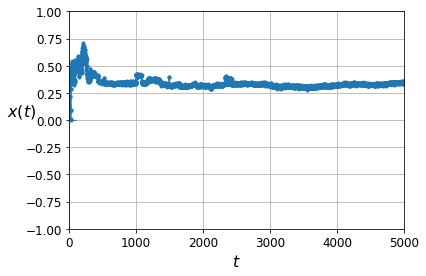

In [12]:
plot_series(X_train[0, :, 0], n_steps_training)

In [13]:
# Define the RNN that will be used

model = get_rnn_model(n_steps_ahead)

In [14]:
history = model.fit(X_train, y_train, epochs=20,)

Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmp6wtd5x96.py, line 12)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmp6wtd5x96.py, line 12)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/1 [==============================] - 4s 4s/step - loss: 0.1206 - last_time_step_mse: 0.1208
Epoch 2/20
1/1 [==============================] - 1s 1s/step - loss: 0.1534 - last_time_step_mse: 0.1577
Epoch 3/20
1/1 [==============================] - 1s 1s/step - loss: 0.0916 - last_time_step_mse: 0.0970
Epoch 4/20
1/1 [==============================] - 1s 1s/step - loss: 0.0537 - las

In [15]:
X_new, Y_new = get_RNN_forecast_sets(scaled_height_and_time_data, 'Scaled Height', n_steps_training, n_steps_forecast, n_steps_ahead )
X = X_new

In [16]:
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

# Y_pred = model.predict(X_new)[..., np.newaxis]

In [17]:

print(X_new.shape)
print(Y_new.shape)
print(Y_pred.shape)

(1, 500, 1)
(1, 500, 1)
(1, 500, 1)


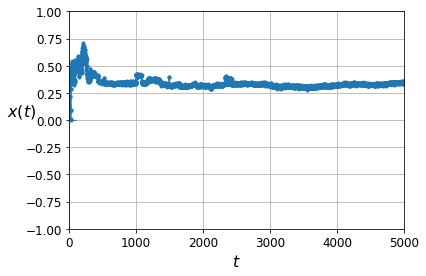

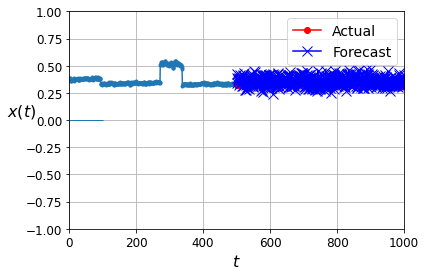

In [18]:
# Plot the entire training set 
plot_series(X_train[0, :, 0], n_steps_training)
plt.show()

# Plot the last n_step_forecast
plot_multiple_forecasts(X_new, Y_new, Y_pred, n_steps_forecast)
# save_fig("forecast_ahead_plot")
plt.show()

In [19]:
# Use a gaussian mixture to remove data points that are statistical outliers

In [20]:
# Define a pipline to clean numerical data
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="most_frequent")),
#     ('std_scaler', StandardScaler()),
])

# Test that the pipeline works
height_data_imputed = num_pipeline.fit_transform(scaled_height_and_time_data)

In [21]:
# Truncate the imputed data to be the number of elements used in the prior training set
height_data_imputed = height_data_imputed[:n_steps_training + n_steps_ahead]

print(height_data_imputed.size)

11000


In [22]:
# scaled_height_and_time_data.plot(kind="scatter", x="Seconds Since Epoch", y="Scaled Height", alpha=0.1)

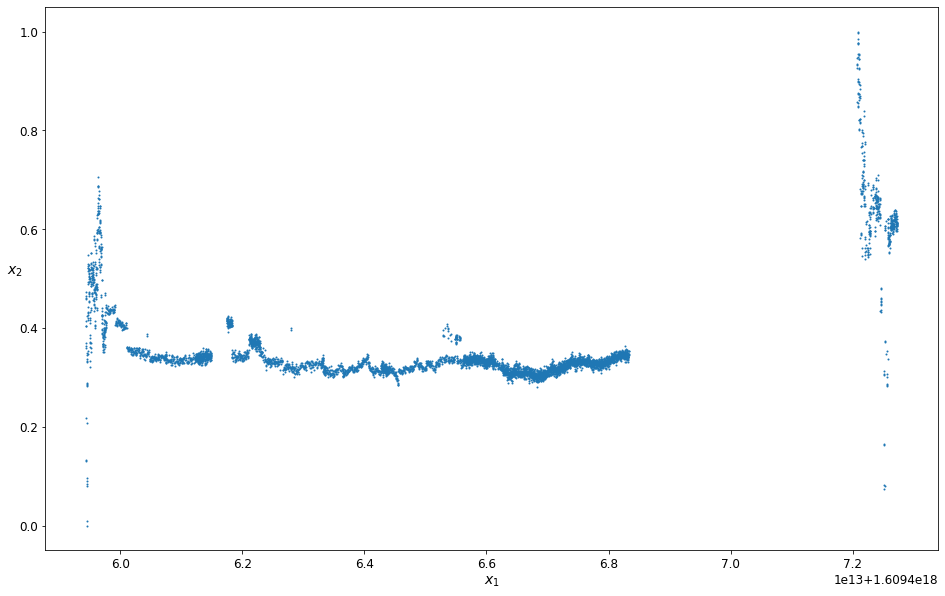

In [23]:
plt.figure(figsize=(16, 10))
plot_clusters(height_data_imputed)
plt.show()

In [24]:
N_COMPONENTS = 1
N_INIT = 10
COVARIANCE_TYPE = "tied"

gm = GaussianMixture(n_components=N_COMPONENTS, n_init=N_INIT,covariance_type=COVARIANCE_TYPE, random_state=42)
gm.fit(height_data_imputed)

GaussianMixture(covariance_type='tied', n_init=10, random_state=42)

In [25]:
height_data_new, y_new = gm.sample(6)
# height_data_new

In [26]:
# y_new

In [27]:
gm.score_samples(height_data_imputed)

array([-30.33492623, -31.63732262, -31.60270461, ..., -32.35585218,
       -32.3673016 , -32.42318644])

In [28]:
resolution = 100
grid = np.arange(-10, 10, 1 / resolution)
xx, yy = np.meshgrid(grid, grid)
X_full = np.vstack([xx.ravel(), yy.ravel()]).T

pdf = np.exp(gm.score_samples(X_full))
pdf_probas = pdf * (1 / resolution) ** 2
pdf_probas.sum()

0.0

/Users/mikedye/Desktop/Code/TZVOLCANO_machine_learning/TZVOLCANO_utilities.py:177: UserWarning: No contour levels were found within the data range.
  plt.contour(xx, yy, Z,


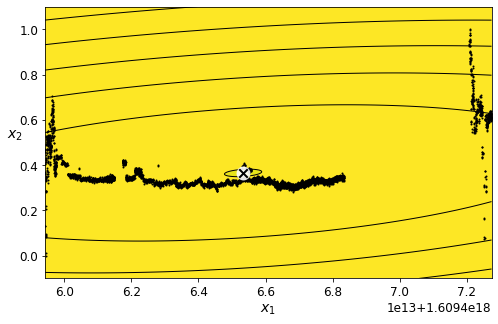

In [29]:
plt.figure(figsize=(8, 5))

plot_gaussian_mixture(gm, height_data_imputed)
# plt.ylim(top=990, bottom=987)
# save_fig("gaussian_mixtures_plot")
plt.show()

/Users/mikedye/Desktop/Code/TZVOLCANO_machine_learning/TZVOLCANO_utilities.py:177: UserWarning: No contour levels were found within the data range.
  plt.contour(xx, yy, Z,


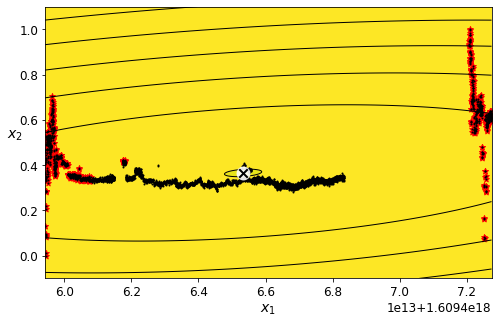

In [30]:
DENSITY_THRESHOLD_PERCENT = 20

densities = gm.score_samples(height_data_imputed)

density_threshold = np.percentile(densities, DENSITY_THRESHOLD_PERCENT)
anomalies = height_data_imputed[densities < density_threshold]



plt.figure(figsize=(8, 5))

plot_gaussian_mixture(gm, height_data_imputed)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='*')
# plt.ylim(top=990, bottom=987)

# save_fig("mixture_anomaly_detection_plot")
plt.show()

<AxesSubplot:xlabel='Seconds Since Epoch'>

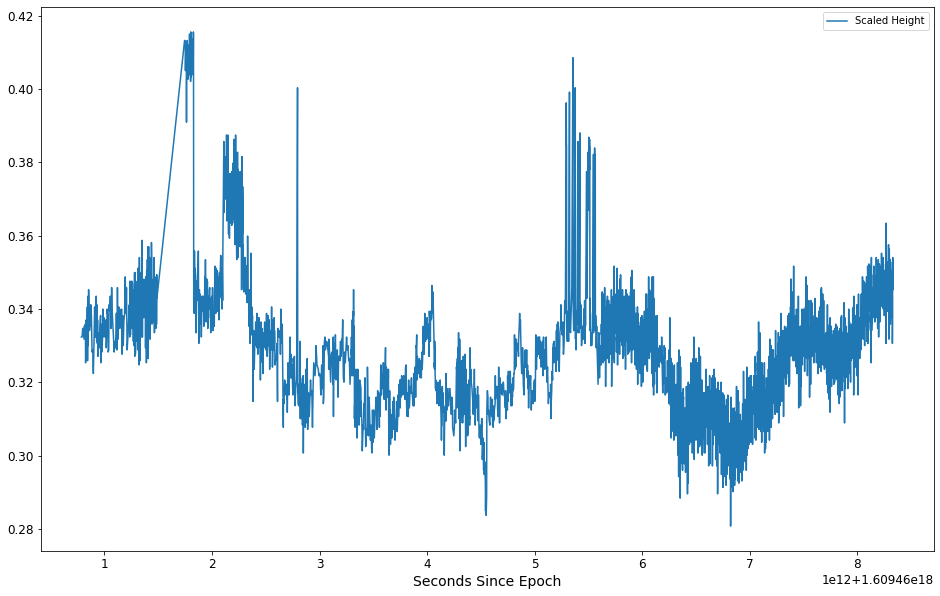

In [31]:
cleaned_data = height_data_imputed[densities >= density_threshold]
cleaned_pandas_data = pd.DataFrame(cleaned_data, columns = ['Seconds Since Epoch','Scaled Height'])
cleaned_pandas_data.plot(x="Seconds Since Epoch", y="Scaled Height",figsize=(16, 10))

In [32]:
# Create a new set of RNN training data based on the cleansed data

# since we removed some points, we no longer have the original number of data points
n_steps_training_truncated = cleaned_pandas_data['Scaled Height'].size

cleaned_RNN_training_data, cleaned_RNN_training_labels = get_RNN_training_sets(cleaned_pandas_data, 'Scaled Height', n_steps_training_truncated)

In [33]:
print(cleaned_RNN_training_data.shape)
print(cleaned_RNN_training_labels.shape)

(1, 4399, 1)
(1, 1)


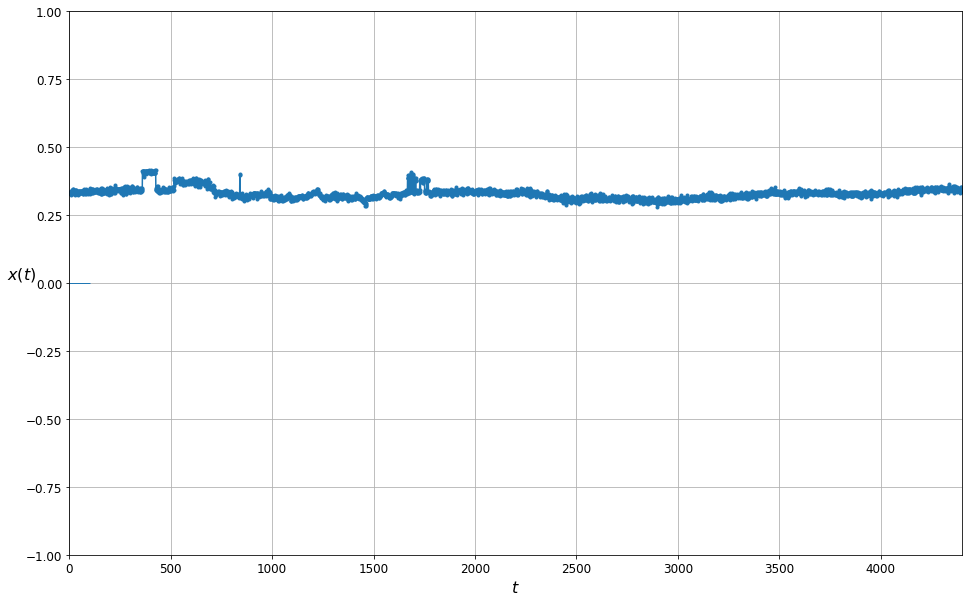

In [34]:
plt.figure(figsize=(16, 10))
plot_series(cleaned_RNN_training_data[0, :, 0], n_steps_training_truncated)

In [35]:
cleaned_model = get_rnn_model(n_steps_ahead)

In [36]:
cleaned_history = cleaned_model.fit(cleaned_RNN_training_data, cleaned_RNN_training_labels, epochs=20,)

Epoch 1/20
1/1 [==============================] - 3s 3s/step - loss: 0.1210 - last_time_step_mse: 0.1209
Epoch 2/20
1/1 [==============================] - 1s 1s/step - loss: 0.1538 - last_time_step_mse: 0.1660
Epoch 3/20
1/1 [==============================] - 1s 916ms/step - loss: 0.0917 - last_time_step_mse: 0.0912
Epoch 4/20
1/1 [==============================] - 1s 878ms/step - loss: 0.0539 - last_time_step_mse: 0.0526
Epoch 5/20
1/1 [==============================] - 1s 876ms/step - loss: 0.0297 - last_time_step_mse: 0.0281
Epoch 6/20
1/1 [==============================] - 1s 883ms/step - loss: 0.0179 - last_time_step_mse: 0.0176
Epoch 7/20
1/1 [==============================] - 1s 1s/step - loss: 0.0140 - last_time_step_mse: 0.0122
Epoch 8/20
1/1 [==============================] - 1s 897ms/step - loss: 0.0109 - last_time_step_mse: 0.0118
Epoch 9/20
1/1 [==============================] - 1s 890ms/step - loss: 0.0068 - last_time_step_mse: 0.0065
Epoch 10/20
1/1 [====================

In [37]:
X_cleaned_new, Y_cleaned_new = get_RNN_forecast_sets(cleaned_pandas_data, 'Scaled Height', n_steps_training_truncated-1, n_steps_forecast, n_steps_ahead)
X_cleaned = X_cleaned_new

In [38]:
Y_cleaned_pred = cleaned_model.predict(X_cleaned_new)[:, -1][..., np.newaxis]

# Y_cleaned_pred = cleaned_model.predict(X_cleaned_new)[..., np.newaxis]

In [39]:
print(X_cleaned_new.shape)
print(Y_cleaned_new.shape)
print(Y_cleaned_pred.shape)

(1, 500, 1)
(1, 500, 1)
(1, 500, 1)


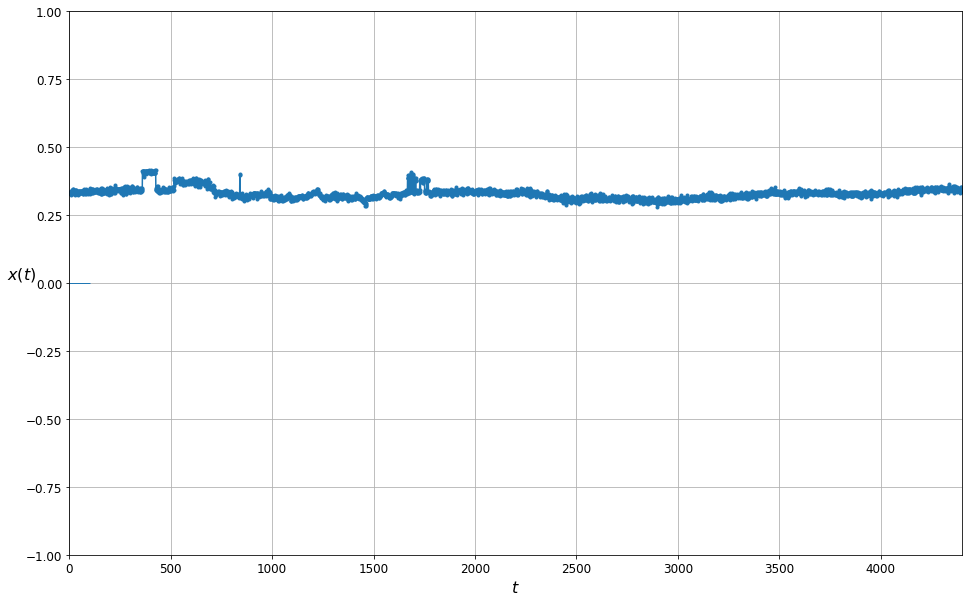

Saving figure forecast_ahead_plot


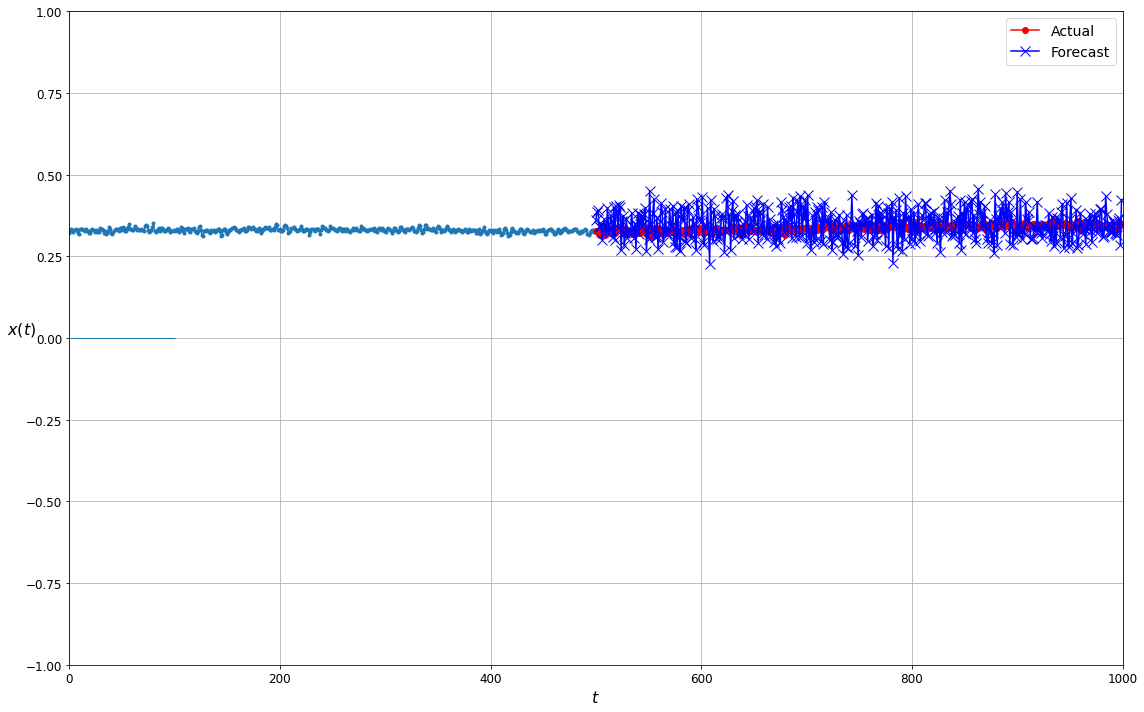

In [40]:
# Plot the entire training set for comparison
plt.figure(figsize=(16, 10))
plot_series(cleaned_RNN_training_data[0, :, 0], n_steps_training_truncated)
plt.show()

plt.figure(figsize=(16, 10))
plot_multiple_forecasts(X_cleaned_new, Y_cleaned_new, Y_cleaned_pred, n_steps_forecast)
save_fig("forecast_ahead_plot")


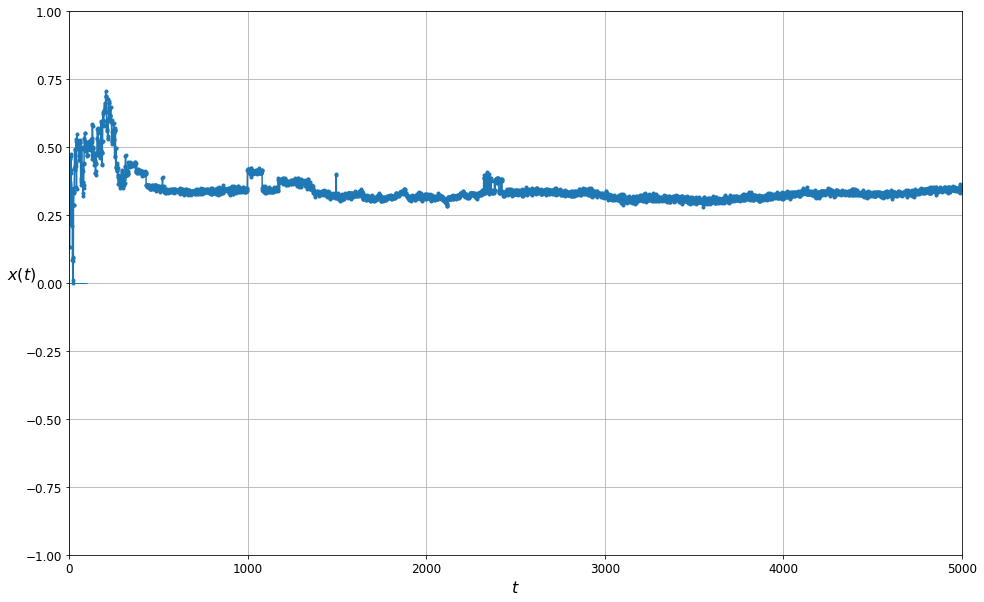

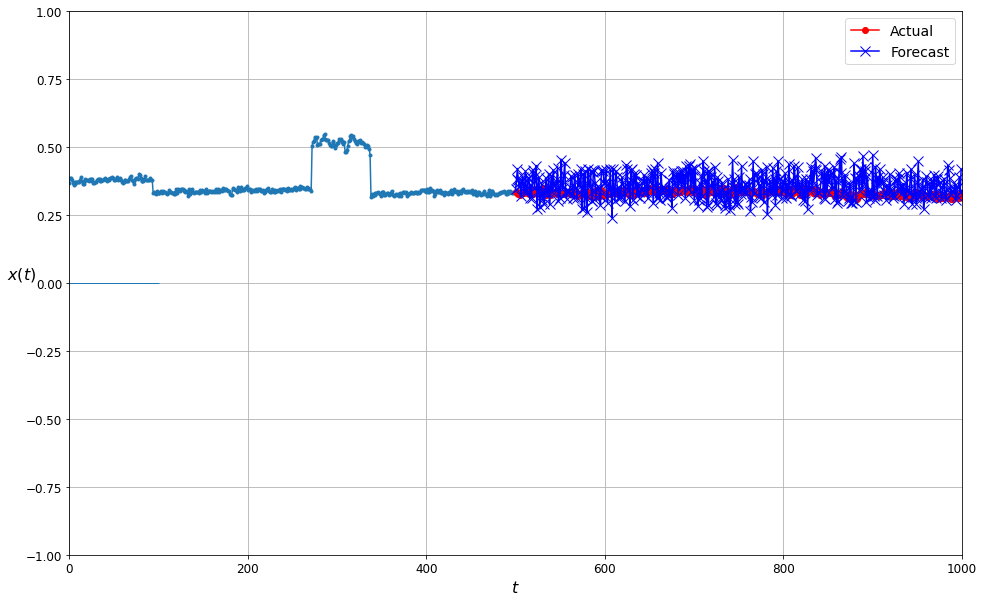

In [41]:
# Plot the entire training set 
plt.figure(figsize=(16, 10))
plot_series(X_train[0, :, 0], n_steps_training)
plt.show()

# Plot the last n_step_forecast
plt.figure(figsize=(16, 10))
plot_multiple_forecasts(X_new, Y_new, Y_pred, n_steps_forecast)
# save_fig("forecast_ahead_plot")
plt.show()